# Synexpression groups identification - Pearson Corrilation

ID: 

Name: Iris Milligan

Last modified: 03.05.2021

## Required Libraries

In [26]:
import pandas as pd
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, colorConverter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [27]:
def print_output_to_file(file_name, data_to_save, sheetName, method):
    # Print output to confirm data format
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    # writer = pd.ExcelWriter(file_name, engine='xlsxwriter', mode=method)
    writer = pd.ExcelWriter(file_name, engine="openpyxl", mode=method)
    # Convert the dataframe to an XlsxWriter Excel object.
    data_to_save.to_excel(writer, sheet_name=sheetName)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()

In [28]:
# Open File to Process
rawdata = pd.read_table("TomoZF10ss.csv",delimiter = ',')

In [29]:
# Import external data
# convert data type

# Mapping ENSEMBL back to GENE name to help label and search operations 
gene_mapping = rawdata
gene_mapping.index = gene_mapping['ENSEMBL']
gene_mapping = gene_mapping[gene_mapping.columns[1:2]]
gene_mapping = gene_mapping.fillna(0)

# now loop through the mapping and convert any gene names = 0 to the ensemble
for row_num, value in enumerate(gene_mapping.index.values):
    if(gene_mapping.iloc[row_num][0]==0):
        gene_mapping.iloc[row_num,0] = value 
    
# set index
rawdata.index = rawdata['ENSEMBL'] 
rawdata = rawdata.drop(['ENSEMBL','gene','name'], axis=1)

# Have to drop Rows where the Gene name aka(index) is Blank
# data = data.loc[data.index.dropna(how='all')]
# To Follow Spactial DB we convert NaN to 0
# rawdata = rawdata.fillna(0)

# need to capture row 0 into a list for mapping later as column names
section_map = rawdata.columns.tolist()

## Now cut the data into the different groups AP, LR and VD

In [30]:
# subset gene

data = rawdata[rawdata.columns[0:51]]
APdata = rawdata[rawdata.columns[0:52]]
LRdata = rawdata[rawdata.columns[52:104]]
VDdata = rawdata[rawdata.columns[104:156]]

# Rename Columns so they align for future plotting.
LRdata.columns=APdata.columns
VDdata.columns=APdata.columns

#Remove Duplicate Columns
APdata = APdata.loc[:,~APdata.columns.duplicated()]
LRdata = LRdata.loc[:,~LRdata.columns.duplicated()]
VDdata = VDdata.loc[:,~VDdata.columns.duplicated()]

#Transpose for future use
APdataT = APdata.T
LRdataT = LRdata.T
VDdataT = VDdata.T 


## Run the section below if you want to get the Pearson's Correlation across the entire data set.

In [31]:
### Create Pearson Correlation 
rawdataT = rawdata.T
pairwise = rawdataT.corr(method='pearson',min_periods=1)
pairwise.columns = gene_mapping['gene'].to_list()
pairwise.index = gene_mapping['gene'].to_list()

# Specify Gene to look at
geneID = "khdrbs1a"
#Testing on ENSDARG00000052402
temp = pairwise[[geneID]]
temp = temp.sort_values(by=geneID,ascending=False)
print(temp.head(n=20))
#print(pairwise.head(n=3))

            khdrbs1a
khdrbs1a    1.000000
ctnnb1      0.988557
cirbp       0.987078
eef1g       0.987063
hmgb2b      0.985700
atp5f1      0.985309
ywhae1      0.985229
eif4a3      0.984937
hsp90ab1    0.984924
sumo3a      0.984838
zgc:158409  0.983777
ywhaba      0.983558
akirin1     0.983368
eif4g2b     0.983249
marcksb     0.982792
rbb4l       0.982788
hnrnpk      0.982591
igf2bp1     0.982569
eef1b2      0.982541
hmgb1b      0.982445


## Run this section if you want to run Pearson's Correlation for each Section (AP, LR & VD)

In [32]:
### Create Pearson Correlation for each slice
### Depending on the Section you want to run uncomment the appropriate section
rawdataT = APdata.T
#rawdataT = LRdata.T
#rawdataT = VDdata.T

pairwise = rawdataT.corr(method='pearson',min_periods=1)
pairwise.columns = gene_mapping['gene'].to_list()
pairwise.index = gene_mapping['gene'].to_list()

# Specify Gene to look at
geneID = "khdrbs1a"
#Testing on ENSDARG00000052402
temp = pairwise[[geneID]]
temp = temp.sort_values(by=geneID,ascending=False)
print(temp.head(n=20))

                  khdrbs1a
si:dkey-10f21.16  1.000000
khdrbs1a          1.000000
cct5              0.985936
hnrnpabb          0.985393
eef1g             0.985037
eif4a3            0.984051
hspa8             0.983557
srsf2a            0.983551
ilf2              0.982622
marcksb           0.982303
wu:fb18c02        0.981673
zgc:123194        0.981515
ptmab             0.981235
ctnnb1            0.981097
seta              0.981016
fth1a             0.980746
hmgn2             0.980445
sumo3a            0.979980
pfdn5             0.979346
smarca5           0.979148


In [33]:
# Build Output list with EnsembleID
i = 0
# Create DataFrame for output
outputPD = pd.DataFrame(columns=["Ensemble","Gene","P-Value"])

while i < 20:
    for row_num, value in enumerate(gene_mapping.index.values):
        if(gene_mapping.iloc[row_num][0]==temp.index.values[i]):
            es1 = value
    outputPD = outputPD.append({'Ensemble' : es1,'Gene' : temp.index.values[i],'P-Value' : temp.values[i]},ignore_index=True)
    i=i+1

# Write to out put file and append s eet: sheetname equal geneID
print_output_to_file("PearOutputbyGene.xlsx",outputPD,geneID,"a")

## Build Line Plots

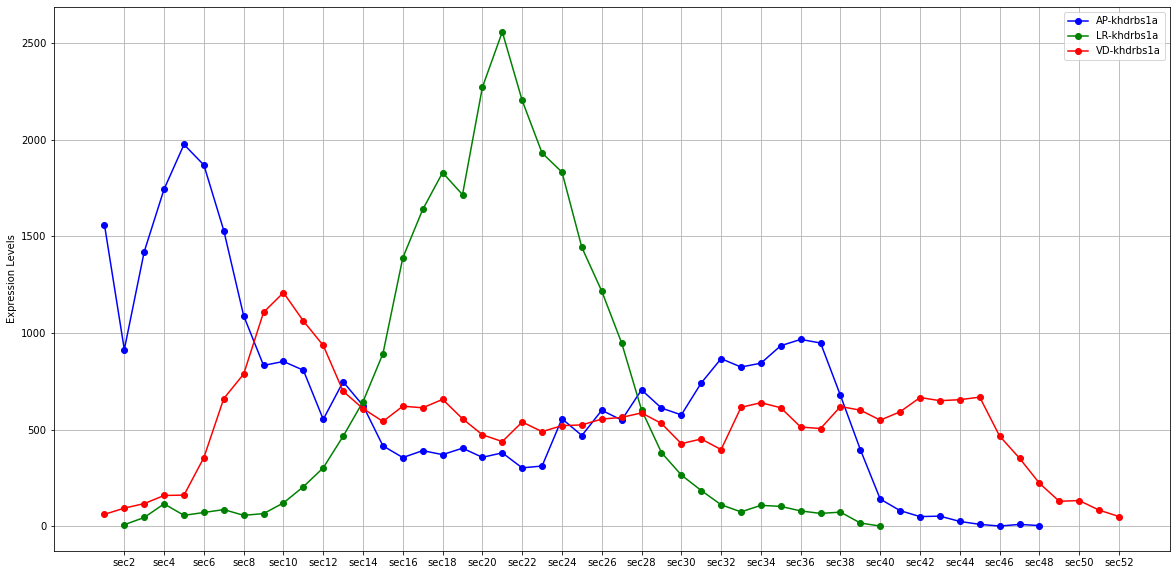

In [34]:
# Generate LinePlot to compare with SpatialDB
ensemblID = gene_mapping.loc[gene_mapping['gene']==geneID]

# Need to build dataframe from AP, LR and VD dataframes to use for Multi-Line plot
lineDF = pd.DataFrame(columns=APdata.columns)
lr1 = pd.DataFrame(columns=APdata.columns)
vd1 = pd.DataFrame(columns=APdata.columns)
lensemb_value=ensemblID.index.values

# Find gene in each of the 3 DataFrames
lineDF=lineDF.append(APdata.loc[lensemb_value,:],ignore_index=True)
lr1=lr1.append(LRdata.loc[lensemb_value,:],ignore_index=True)
vd1=vd1.append(VDdata.loc[lensemb_value,:],ignore_index=True)

# Now append results into 1 DataFrame
lineDF=lineDF.append(lr1,ignore_index=True)
lineDF=lineDF.append(vd1,ignore_index=True)

# Transpose ne DataFrame
lineDFT = lineDF.T

# Set Labels
lineDFT.columns=['AP-'+geneID,'LR-'+geneID,'VD-'+geneID]

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
markers=['o','d','s']
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list,color=["blue","green","red"],marker='o', ylabel="Expression Levels")
plt.show()

## Build line plots for the AP, LR and VD represemntations of the top genes

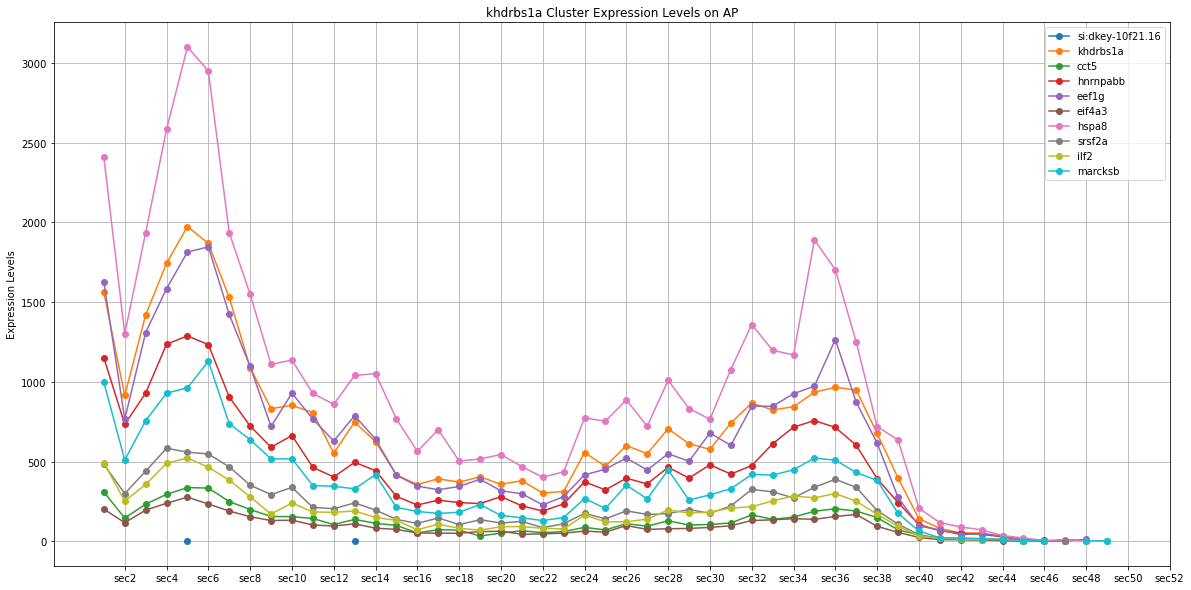

In [35]:
# Generate LinePlot to compare with SpatialDB
plotlist = temp.index.to_list()
plotgenes = plotlist[:10]

# Loop through list and build data for line plot
i = 0
APdata.index = gene_mapping['gene'].to_list()

APdataT = APdata.T
lineDF = pd.DataFrame(columns=APdata.columns)

while i < 10:
    geneIDList = plotgenes[i]
    lineDF = lineDF.append(APdata.loc[geneIDList],ignore_index=False)
    i = i+1    

# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]
# Set Labels
lineDFT.columns=plotgenes

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list, marker='o', ylabel="Expression Levels",title=geneID+" Cluster Expression Levels on AP")
plt.show()

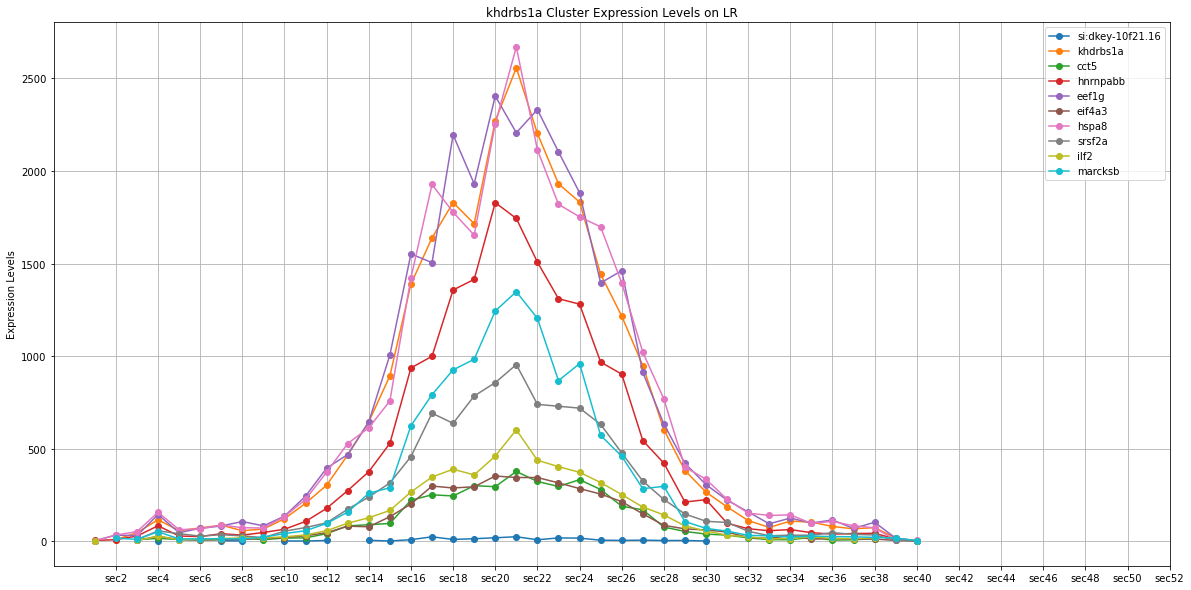

In [36]:
# Generate LinePlot to compare with SpatialDB
plotlist = temp.index.to_list()
plotgenes = plotlist[:10]

# Loop through list and build data for line plot
i = 0
LRdata.index = gene_mapping['gene'].to_list()

LRdataT = LRdata.T
lineDF = pd.DataFrame(columns=LRdata.columns)

while i < 10:
    geneIDList = plotgenes[i]
    lineDF = lineDF.append(LRdata.loc[geneIDList],ignore_index=False)
    i = i+1    


# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]
# Set Labels
lineDFT.columns=plotgenes

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list, marker='o', ylabel="Expression Levels",title=geneID + " Cluster Expression Levels on LR")
plt.show()

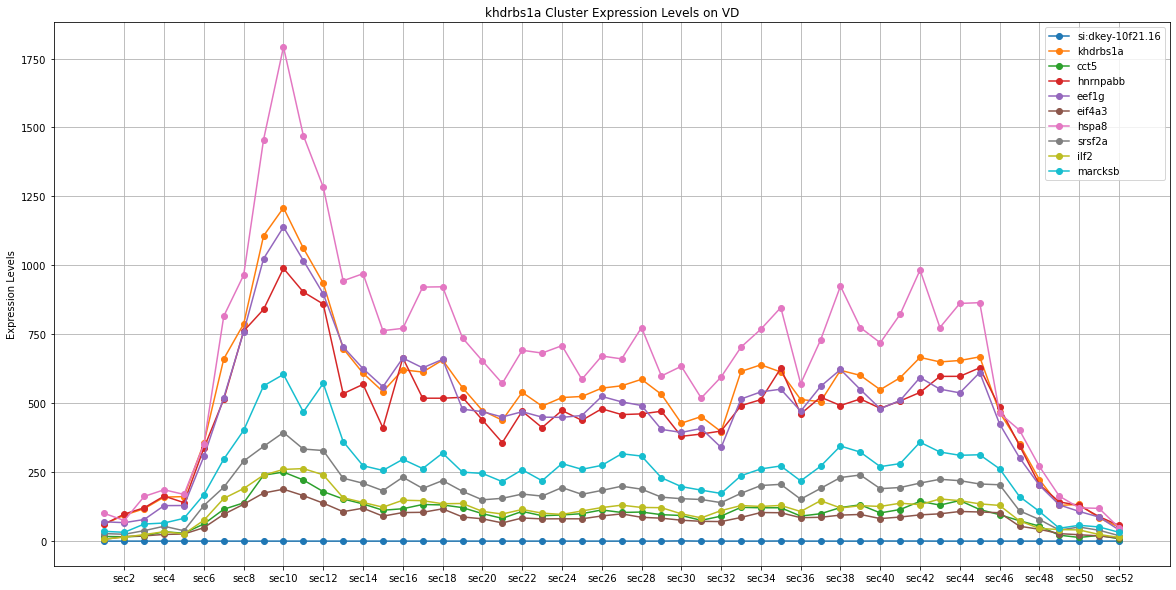

In [42]:
# Generate LinePlot to compare with SpatialDB
plotlist = temp.index.to_list()
plotgenes = plotlist[:10]

# Loop through list and build data for line plot
i = 0
VDdata.index = gene_mapping['gene'].to_list()

VDdataT = VDdata.T
lineDF = pd.DataFrame(columns=VDdata.columns)

while i < 10:
    geneIDList = plotgenes[i]
    lineDF = lineDF.append(VDdata.loc[geneIDList],ignore_index=False)
    i = i+1    

# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]
# Set Labels
lineDFT.columns=plotgenes

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list, marker='o', ylabel="Expression Levels",title=geneID + " Cluster Expression Levels on VD")
plt.show()

In [38]:
#Label Gene Section 1-10 based on Quintile value
def LabelFunc2(xvalue,icolumn):
    if(xvalue<=quant.iloc[0][icolumn]): retvalue = "0"
    elif(xvalue<=quant.iloc[1][icolumn]): retvalue = "10"
    elif(xvalue<=quant.iloc[2][icolumn]): retvalue = "20"
    elif(xvalue<=quant.iloc[3][icolumn]): retvalue = "30" 
    elif(xvalue<=quant.iloc[4][icolumn]): retvalue = "40"
    elif(xvalue<=quant.iloc[5][icolumn]): retvalue = "50" 
    elif(xvalue<=quant.iloc[6][icolumn]): retvalue = "60"
    elif(xvalue<=quant.iloc[7][icolumn]): retvalue = "70" 
    elif(xvalue<=quant.iloc[8][icolumn]): retvalue = "80"
    elif(xvalue<=quant.iloc[9][icolumn]): retvalue = "90" 
    else: retvalue = "100"
    return retvalue 

<AxesSubplot:title={'center':'AP Sections'}>

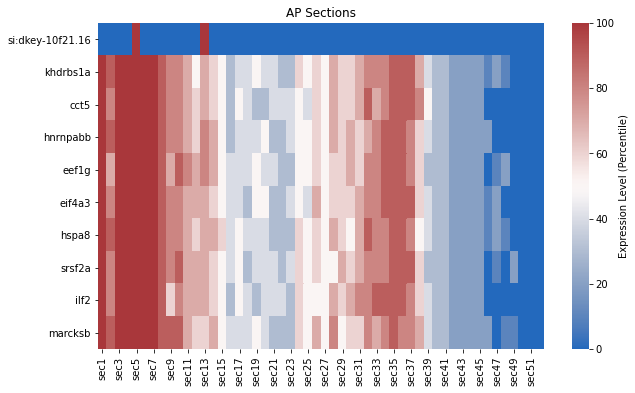

In [39]:
# Generate New DataFrame from list of genes
labelsArray = pd.DataFrame()
plotlist = temp.index.to_list()
geneList1 = plotlist[:10]
#geneList1 = ['tgfb2','ptbp3','syngr2a','hoxc4a','NDUFA3','ost4','gltpa','slc1a7a','DHRS2','xrcc6bp1']

# Create new DataFrame to hold values
genePD1 = pd.DataFrame(columns=APdata.columns)
lineDF = pd.DataFrame(columns=APdata.columns)
firstline = True

# Need to build dataframe from AP for heatmaps
i = 0
while i < 10:
    geneIDList = geneList1[i]
    lineDF = lineDF.append(APdata.loc[geneIDList],ignore_index=False)
    i = i+1    

lineDF = lineDF.fillna(0)
# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]

genePD1 = lineDFT.T
    
# Next Convert to Quintels to normalize the data
genePD1T = genePD1.T
quant1 = genePD1T

quant = genePD1T.quantile([.0,.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

# Logic loop through new dataframe and label values by percents
Cols = len(quant1.columns)
Rows = len(quant1)
p=0
q=0

while q < Cols:
    p=0
    while p < Rows:
        z = genePD1T.iloc[p][q]
        ret1 =LabelFunc2(z,q)
        # Instead of print write to excel cell 
        quant1.iloc[p][q] = ret1
        p=p+1
    q=q+1

quant1T = quant1.T

# Now Generate Heatmap
# Generate Clustermap but focused on top 20% of releations
plt.figure(figsize=(10, 6))

ax = plt.axes()
ax.set_title('AP Sections')
p1 = sns.heatmap(quant1T, cbar_kws={'label': 'Expression Level (Percentile)'},cmap="vlag")
display(p1)

<AxesSubplot:title={'center':'LR Sections'}>

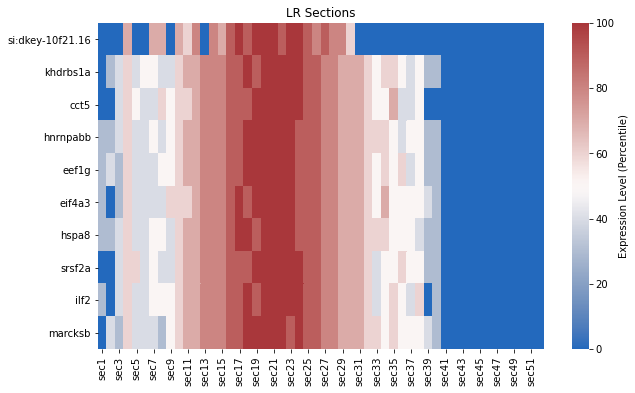

In [40]:
# Generate New DataFrame from list of genes
labelsArray = pd.DataFrame()
plotlist = temp.index.to_list()
geneList1 = plotlist[:10]
#geneList1 = ['tgfb2','ptbp3','syngr2a','hoxc4a','NDUFA3','ost4','gltpa','slc1a7a','DHRS2','xrcc6bp1']

# Create new DataFrame to hold values
genePD1 = pd.DataFrame(columns=LRdata.columns)
lineDF = pd.DataFrame(columns=LRdata.columns)
firstline = True

# Need to build dataframe from AP for heatmaps
i = 0
while i < 10:
    geneIDList = geneList1[i]
    lineDF = lineDF.append(LRdata.loc[geneIDList],ignore_index=False)
    i = i+1    

lineDF = lineDF.fillna(0)
# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]

genePD1 = lineDFT.T
    
# Next Convert to Quintels to normalize the data
genePD1T = genePD1.T
quant1 = genePD1T

quant = genePD1T.quantile([.0,.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

# Logic loop through new dataframe and label values by percents
Cols = len(quant1.columns)
Rows = len(quant1)
p=0
q=0

while q < Cols:
    p=0
    while p < Rows:
        z = genePD1T.iloc[p][q]
        ret1 =LabelFunc2(z,q)
        # Instead of print write to excel cell 
        quant1.iloc[p][q] = ret1
        p=p+1
    q=q+1

quant1T = quant1.T

# Now Generate Heatmap
# Generate Clustermap but focused on top 20% of releations
plt.figure(figsize=(10, 6))

ax = plt.axes()
ax.set_title('LR Sections')
p1 = sns.heatmap(quant1T, cbar_kws={'label': 'Expression Level (Percentile)'},cmap="vlag")
display(p1)

<AxesSubplot:title={'center':'VD Sections'}>

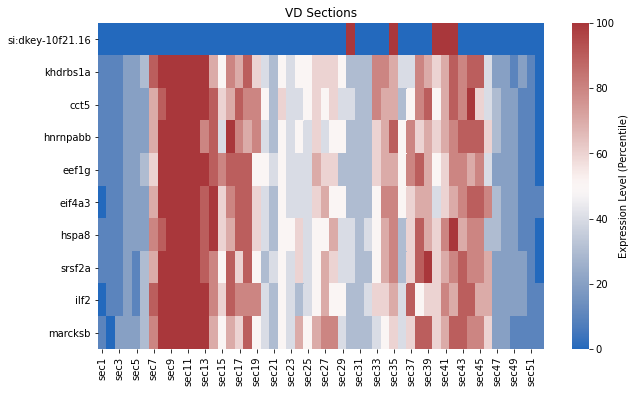

In [41]:
# Generate New DataFrame from list of genes
labelsArray = pd.DataFrame()
plotlist = temp.index.to_list()
geneList1 = plotlist[:10]
#geneList1 = ['tgfb2','ptbp3','syngr2a','hoxc4a','NDUFA3','ost4','gltpa','slc1a7a','DHRS2','xrcc6bp1']

# Create new DataFrame to hold values
genePD1 = pd.DataFrame(columns=VDdata.columns)
lineDF = pd.DataFrame(columns=VDdata.columns)
firstline = True

# Need to build dataframe from AP for heatmaps
i = 0
while i < 10:
    geneIDList = geneList1[i]
    lineDF = lineDF.append(VDdata.loc[geneIDList],ignore_index=False)
    i = i+1    

lineDF = lineDF.fillna(0)
# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]

genePD1 = lineDFT.T
    
# Next Convert to Quintels to normalize the data
genePD1T = genePD1.T
quant1 = genePD1T

quant = genePD1T.quantile([.0,.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

# Logic loop through new dataframe and label values by percents
Cols = len(quant1.columns)
Rows = len(quant1)
p=0
q=0

while q < Cols:
    p=0
    while p < Rows:
        z = genePD1T.iloc[p][q]
        ret1 =LabelFunc2(z,q)
        # Instead of print write to excel cell 
        quant1.iloc[p][q] = ret1
        p=p+1
    q=q+1

quant1T = quant1.T

# Now Generate Heatmap
# Generate Clustermap but focused on top 20% of releations
plt.figure(figsize=(10, 6))

ax = plt.axes()
ax.set_title('VD Sections')
p1 = sns.heatmap(quant1T, cbar_kws={'label': 'Expression Level (Percentile)'},cmap="vlag")
display(p1)


In [17]:
pairwise = pairwise.fillna(0)

In [18]:
# Generate Dendrogram

from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette

pearcorr = pairwise

# Plot Dendrogram
# Setup Plot Size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import seaborn as sns
sns.set_style("whitegrid")

lnk=linkage(pearcorr, metric='correlation', method='complete')

link_4 = cut_tree(lnk,n_clusters = 4)

pd.crosstab(index=rawdata.index, columns = link_4.T[0],rownames = ['Sec'], colnames = ['gne'])
fig, ax = plt.subplots(1,1,figsize = (12,10))

#dn = dendrogram(lnk, labels=list(data.columns), leaf_font_size = 8, show_leaf_counts = True)
dn = dendrogram(lnk, labels=list(rawdataT.columns), leaf_font_size = 8, show_leaf_counts = True)
plt.axhline(y=1.0, c='k', ls='dashed')
plt.show()

Text(0.5, 0.98, 'VD Axis')

<Figure size 1152x432 with 0 Axes>

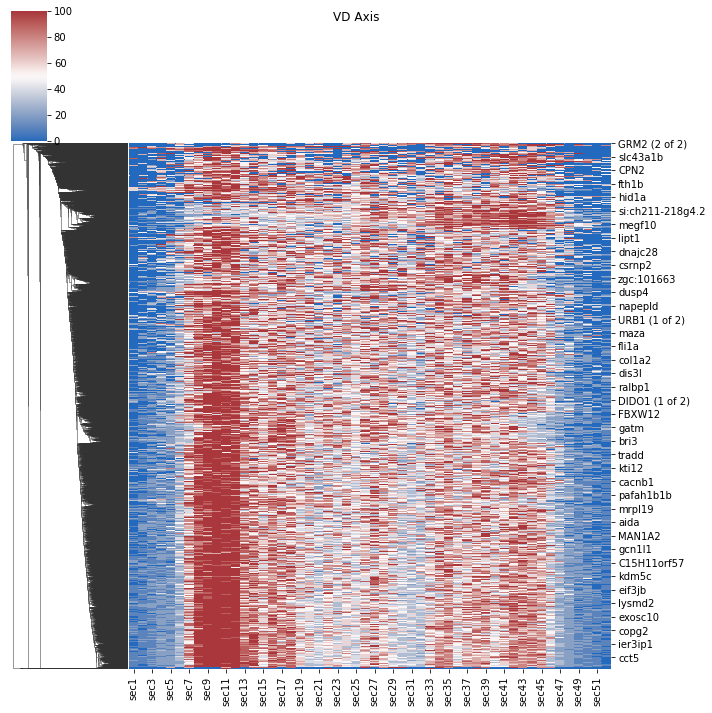

In [25]:
# Generate New DataFrame from list of genes
lineDF = VDdata.fillna(0)
lineDF.index = gene_mapping['gene'].to_list() 

# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]

genePD1 = lineDFT.T
    
# Next Convert to Quintels to normalize the data
genePD1T = genePD1.T
quant1 = genePD1T

quant = genePD1T.quantile([.0,.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

# Logic loop through new dataframe and label values by percents
Cols = len(quant1.columns)
Rows = len(quant1)
p=0
q=0

while q < Cols:
    p=0
    while p < Rows:
        z = genePD1T.iloc[p][q]
        ret1 =LabelFunc2(z,q)
        # Instead of print write to excel cell 
        quant1.iloc[p][q] = ret1
        p=p+1
    q=q+1

quant1T = quant1.T

# Now Generate Heatmap
# Generate Clustermap but focused on top 20% of releations

# Build Heatmap
plt.figure(figsize=(16, 6))
p1 = sns.clustermap(quant1T,cmap="vlag",col_cluster=False)
p1.fig.suptitle("VD Axis")


<AxesSubplot:title={'center':'LR Sections'}>

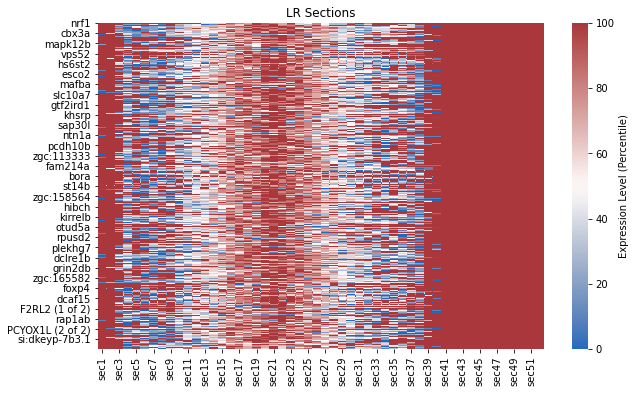

In [19]:
plt.figure(figsize=(10, 6))

ax = plt.axes()
ax.set_title('LR Sections')
p1 = sns.heatmap(quant1T, cbar_kws={'label': 'Expression Level (Percentile)'},cmap="vlag")
display(p1)